In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from multiprocessing import Pool

In [43]:
colormap = cm.tab10

# General purpose functions

In [44]:
def generate_patterns(pattern_lenght: int, N: int, q: float = 0.5):
  """
  Args:
    pattern_lenght (int): \n
    N (int): Number of patterns generated \n
    q (float): Probability of each element of having value -1 \n
  Returns:
    patterns (ndarray): Array of shape (`N`, `pattern_lenght`) containing in each of its rows a different casual pattern 
  """
  try:
    assert (q >= 0) and (q <= 1)
  except:
    print("q must be in the range [0,1]")
    return
  return np.random.choice([-1,1], size=(N,pattern_lenght), p=[q, 1-q])

In [45]:
def corrupt_patterns(patterns: np.ndarray, q: float = 0.1):
  """
  Args:
    patterns (ndarray):
    q (float): probability of each spin to change value
  Returns:
    corrupted_patterns (ndarray): 
  """
  try:
    assert q >= 0 and q <= 1
  except:
    print("q must have a value between 0 and 1 (included)")
    return
  
  corrupted = patterns.copy()
  choice = np.random.choice([0,1], size=corrupted.shape, p=[1-q, q])
  corrupted = np.where(choice == 0, corrupted, -corrupted)
  """
  for p in corrupted:
    choice = np.random.choice([0,1], size=p.shape, p=[1-q, q])
    p[:] = np.where(choice == 0, p, -p)
  """
  return corrupted


# Section 1

# Section 2

# Section 3: Modern Hopfield Network

This model is a generalization of the original Hopfield network and first appeared in an article by Krotov and Hofield in 2016 [1]. 
It considers a new energy function defined as:
\begin{equation*}
  E (\sigma) = - \sum_{\mu = 1}^K F \left( \xi_\mu \cdot \sigma \right)
\end{equation*}
where $\{\xi_{\mu}\}_{\mu=1}^K$ are the $K$ different patterns stored in memory and $\sigma$ is the new pattern we want to know the energy of. 
We implemented three different types of function:
- polynomial function of degree $n$:
\begin{equation*}
  F(x) = x^n
\end{equation*}
- rectified polynomial function of degree $n$:
\begin{equation*}
  F(x) = \left\{
  \begin{array}{lr}
    x^n & x \geq 0 \\
    0 & x < 0
  \end{array}
  \right.
\end{equation*}
- exponential function (this one was proposed in [2] as the limit $n \to \infty$ of the polynomial one):
\begin{equation*}
  F(x) = e^{x}
\end{equation*}

We can see how, if we consider $F(x)$ as a polynomial of order 2, the model is equivalent to the original Hopfield network described above.

A new update function was also devised:

\begin{equation*} 
  \sigma^{(t+1)}_i = \mathrm{sign} \left[ \sum_{\mu=1}^K \left( F \left( \xi_i^{\mu} + \sum_{j \neq i} \xi_j^{\mu} \sigma_j^{(t)} \right) 
  - F \left( - \xi_i^{\mu} + \sum_{j \neq i} \xi_j^{\mu} \sigma_j^{(t)} \right) \right) \right]
\end{equation*}

[1] D. Krotov and J. J. Hopfield, "Dense associative memory for pattern recognition" in *Proc. Adv. Neural Inf. Process. Syst.*, vol. 29, 2016, pp. 1172–1180.


In [46]:
class modern_hopfield():
  
  def __init__(self, pattern_lenght: int, func_type: str = "Polyn", poly_deg: int = 3):
    """
    Args:
        pattern_lenght (int): Lenght of each pattern stored in the network 
        func_type (str): Type of function used to evaluate the energy of a single pattern. Possible options are "Polyn", "RePn", "Exp" \n
        poly_deg (int): Degree of the polynomial function used in the evaluation of the energy
    """
    self.pattern_lenght = pattern_lenght
    self.memory_matrix = np.zeros(shape=(1,self.pattern_lenght))
    self.func_type = func_type
    self.deg = poly_deg
    return
  
  def add_patterns(self, p: np.ndarray):
    """
    Args:
        p (ndarray): pattern to add to memory
    """
    if self.memory_matrix[0,0]==0:
      self.memory_matrix = p
    else:
      self.memory_matrix = np.vstack((self.memory_matrix, p))
    return

  def retrieve_pattern(self, p: np.ndarray, epochs: int):
    """
    Args:
        p (ndarray): input pattern  \n
        epochs (int): maximum number of iterations \n
    performs the update rule up to `epochs` times, trying to match the input pattern `p` to a pattern stored in memory     
    """
    sigma = p.copy()
    for epoch in range(epochs):
      sigma = self._update_rule(sigma)
    return sigma

  def energy(self, sigma: np.ndarray):
    """
    Args:
        sigma (ndarray):
    Computes the energy of the pattern `sigma`
    """
    return - np.sum(self._F(np.dot(self.memory_matrix, sigma)))

  def _update_rule(self, sigma: np.ndarray):
    """
    Args:
        sigma (ndarray): vector containing the values of the network's neurons at time t. \n 
    Returns the values of the network's neurons at time t+1 
    """
    s = 0
    for xi in self.memory_matrix:
      s += self._F(xi + np.dot(xi, sigma) - np.multiply(xi, sigma)) - self._F(-xi + np.dot(xi, sigma) - np.multiply(xi, sigma))
    return np.sign(s)

  def _F(self, x: np.ndarray):
    """
    Different types of function:
    - `Polyn`: polynomial function of degree n
    - `RePn`: rectified polynomial function of degree n
    - `Exp`: exponential function
    """
    match self.func_type:
      case "Polyn":
        return x**self.deg
      case "RePn":
        return np.where(x > 0, x**self.deg, 0)
      case "Exp":
        return np.exp(x)
      

## Number of maximum patterns retrievable

As stated in [1], the maximum number of patterns this type of network is able to recover without error is:
\begin{equation*}
  K_{\text{no errors}}^{\text{max}} \approx \frac{1}{2 (2 n - 3) !!} \frac{N^{n-1}}{\ln N}
\end{equation*}
where $N$ is the number of neurons. 

We will now test this finding with our model.

In [47]:
def _double_factorial(N: int):
  if N > 0:
    return N * _double_factorial(N - 2)
  else:
    return 1

def maximum_recall(pattern_lenght: int, degree: int):
  """
  Returns the expected number of patterns a modern hopfield network of size `pattern_lenght` 
  whose energy functions is a polynomial of order `degree` can recall
  """
  return pattern_lenght**(degree - 1) / (2 * _double_factorial(2 * degree - 3) * np.log(pattern_lenght)) 

In [48]:
# hyperparameters of the analysis
pattern_lenght = 25
n_patterns = [1, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
epochs = 10
max_order = 5
test_size = 20

In [49]:
# we first compute the expected value of k_max given by the formula above 
expected_kmax = []
for d in range(2, max_order+1):
  expected_kmax.append(maximum_recall(pattern_lenght, d))
expected_kmax = np.array(expected_kmax)
print(expected_kmax)

[  3.88334334  32.36119451 161.80597254 577.87847336]


In [50]:
# we now compute the accuracy of our model in the retrieving task

results = []
for n in range(2, max_order+1):
  accuracy = []
  for L in n_patterns:
    # generating L patterns and saving them to memeory 
    patterns = generate_patterns(pattern_lenght=pattern_lenght, N=L)
    model = modern_hopfield(pattern_lenght=pattern_lenght, func_type="Polyn", poly_deg=n)
    model.add_patterns(patterns)

    # we now select a subset of patterns to test our model
    perm = np.random.permutation(patterns.shape[0])
    ts = np.minimum(test_size, L)
    test_patterns = patterns[perm, :][:ts,:]
    
    # computing the accuracy
    acc = 0
    for i, p in enumerate(test_patterns):
      r = model.retrieve_pattern(p=p, epochs=epochs)
      if np.array_equal(test_patterns[i,:], r):
        acc += 1
    acc /= ts
    accuracy.append(acc)
  results.append(accuracy)

results = np.array(results)

print(results)

[[1.   0.5  0.   0.   0.   0.   0.   0.   0.05 0.  ]
 [1.   1.   0.9  0.8  0.3  0.   0.   0.   0.   0.  ]
 [1.   1.   1.   1.   0.95 0.85 0.1  0.1  0.   0.  ]
 [1.   1.   1.   1.   1.   0.95 1.   0.4  0.05 0.  ]]


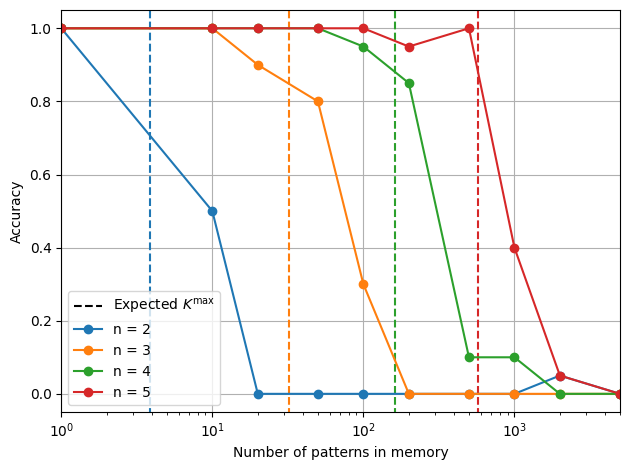

In [51]:
# let's visualize it
fig, ax = plt.subplots()

# plotting of the accuracies
for d in range(max_order - 1):
  ax.errorbar(n_patterns, results[d,:], fmt="o-", alpha=1, label=f"n = {d+2}", color=colormap.colors[d])

# plotting of the expected k_max
for i in range(expected_kmax.shape[0]):
  ax.vlines(expected_kmax[i], ymin=-1, ymax=2, linestyles="--", colors=colormap.colors[i])


# this is just for legend purposes
ax.vlines(0, ymin=0, ymax=0, label=r"Expected $K^{\text{max}}$", linestyles="--", colors='black')


ax.set_xscale('log')
ax.set_xlim(n_patterns[0], n_patterns[-1])
ax.set_ylim(-0.05, 1.05)

ax.set_xlabel("Number of patterns in memory")
ax.set_ylabel("Accuracy")

ax.legend()
ax.grid()

fig.tight_layout()

We can see how our model capacity increases as the degree of the polynomial increases and it reflects the estimation given in [1].

## Retrieval of corrupted patterns
We now want to test the accuracy of our model in retrieving patterns from memory that have been corrupted.
The corruption process utilized consists in flipping any neuron of a pattern with a certain probability $q$. 
Given the nature of our neurons (either having value +1 or -1) we have that the maximum amount of corruption (basically complete randomness) will be reached for $q \sim 0.5$, and we can see that corrupting a patter with $q=1$ will give us the "negative" of the pattern (every spin has its sign changed).

Let's start by testing how changing the function type affects the model ability to retrieve patterns.

In [52]:
# hyperparameters of the analysis
pattern_lenght = 100
n_patterns = 100
func_type = ["Polyn", "RePn", "Exp"]
poly_deg = 5

epochs = 10
test_size = 20
n_trials = 10
corruption_steps = 11

In [53]:
def corruption_func_type_analysis(func_type: str):
  """
  `func_type`: function type to initialize the model \n

  Returns the accuracy of the model for each quantity of corruption. The process is repeated `n_trials` times.
  """

  ts = np.minimum(n_patterns, test_size)

  accuracy = []
  for i in range(n_trials):
    # initialization of the model and creation of the patterns
    model = modern_hopfield(pattern_lenght=pattern_lenght, func_type=func_type, poly_deg=poly_deg)
    patterns = generate_patterns(pattern_lenght=pattern_lenght, N=n_patterns)
    model.add_patterns(patterns)

    # we now test our model over different (from 0 to 1) probabilities of corruption
    corruption_prob = np.linspace(0, 1, corruption_steps)
    correctly_identified = []
    for q in corruption_prob:
      # selecting a subset of patterns for testing
      perm = np.random.permutation(patterns.shape[0])
      test_patterns = patterns[perm, :][:ts,:]
      corrupted = corrupt_patterns(patterns=test_patterns, q=q)

      # counting how many tests where succesessful
      c_id = 0 
      for i, c in enumerate(corrupted):
        r = model.retrieve_pattern(c, epochs=epochs)
        if np.array_equal(test_patterns[i,:], r): 
          c_id += 1
      correctly_identified.append(c_id)
    accuracy.append(np.array(correctly_identified) / ts)
  return np.array(accuracy)

In [54]:
# multithreading to speed up the process
pool = Pool(len(func_type))
results = pool.map(corruption_func_type_analysis, func_type)

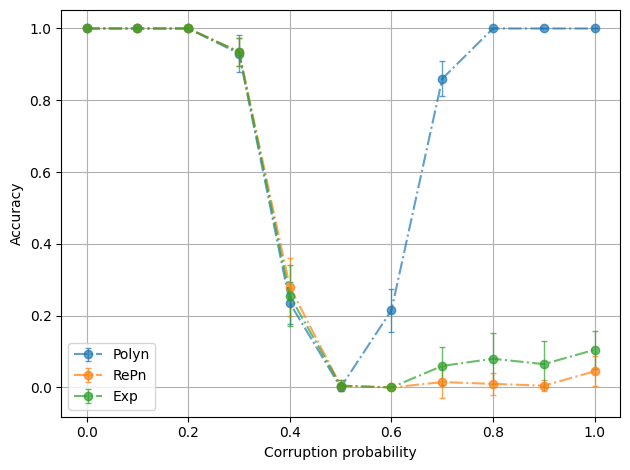

In [55]:
# plotting the results
fig, ax = plt.subplots()

for i, r in enumerate(results):
  ax.errorbar(np.linspace(0,1,corruption_steps), np.mean(r, axis=0), yerr=np.std(r, axis=0), label=func_type[i],
              fmt='o-.', capsize=2, alpha=0.7, elinewidth=1, color=colormap.colors[i])

ax.set_xlabel("Corruption probability")
ax.set_ylabel("Accuracy")

ax.legend(loc='lower left')
ax.grid()
fig.tight_layout()

We can see how the three different functions perform similarly for $q \leq 0.5$. However for $q > 0.5$ the polynomial one greatly outperforms the others as it is able to restore "negative" patterns back to their original form.
From now on we will use this function unless stated otherwise.

Another parameter to test is the degree of the polynomial.

In [66]:
# hyperparameters of the analysis
pattern_lenght = 100
n_patterns = 100
func_type = "Polyn"
poly_deg = [3, 4, 5, 6, 7, 8, 9]

epochs = 10
test_size = 20
n_trials = 10
corruption_steps = 11

In [67]:
def corruption_degree_analysis(poly_deg: int):
  """
  `epochs`: number of times the update function is used \n

  Returns the accuracy of the model for each quantity of corruption. The process is repeated `n_trials` times.
  """

  ts = np.minimum(n_patterns, test_size)

  accuracy = []
  for i in range(n_trials):
    # initialization of the model and creation of the patterns
    model = modern_hopfield(pattern_lenght=pattern_lenght, func_type=func_type, poly_deg=poly_deg)
    patterns = generate_patterns(pattern_lenght=pattern_lenght, N=n_patterns)
    model.add_patterns(patterns)

    # we now test our model over different (from 0 to 1) probabilities of corruption
    corruption_prob = np.linspace(0, 1, corruption_steps)
    correctly_identified = []
    for q in corruption_prob:
      # selecting a subset of patterns for testing
      perm = np.random.permutation(patterns.shape[0])
      test_patterns = patterns[perm, :][:ts,:]
      corrupted = corrupt_patterns(patterns=test_patterns, q=q)

      # counting how many tests where succesessful
      c_id = 0 
      for i, c in enumerate(corrupted):
        r = model.retrieve_pattern(c, epochs=epochs)
        if np.array_equal(test_patterns[i,:], r): 
          c_id += 1
      correctly_identified.append(c_id)
    accuracy.append(np.array(correctly_identified) / ts)
  return np.array(accuracy)

In [68]:
# multithreading to speed up the process
pool = Pool(len(poly_deg))
results = pool.map(corruption_degree_analysis, poly_deg)

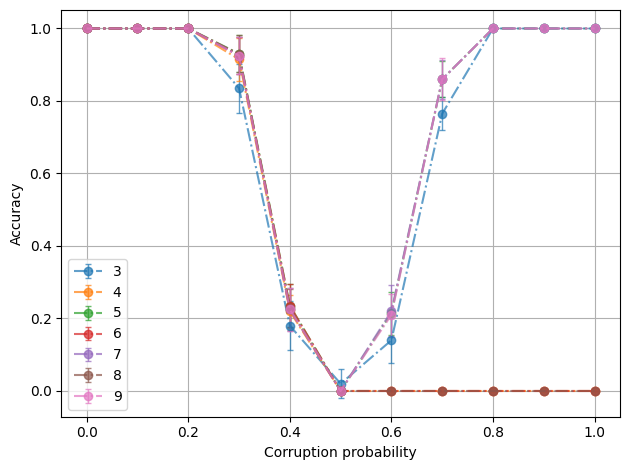

In [69]:
# plotting the results
fig, ax = plt.subplots()

for i, r in enumerate(results):
  ax.errorbar(np.linspace(0,1,corruption_steps), np.mean(r, axis=0), yerr=np.std(r, axis=0), label=poly_deg[i],
              fmt='o-.', capsize=2, alpha=0.7, elinewidth=1, color=colormap.colors[i])

ax.set_xlabel("Corruption probability")
ax.set_ylabel("Accuracy")

ax.legend(loc='lower left')
ax.grid()
fig.tight_layout()

We can observe how the best performance is obtained for $n \geq 5$ odd. For $n$ even the model isn't able to correcly identify the "negative" of a pattern.

We now want to test the ideal number of iterations that the retrieval algorithm should use to obtain the best performance. 

In [70]:
# hyperparameters of the analysis
pattern_lenght = 100
n_patterns = 100
func_type = "Polyn"
poly_deg = 5

epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
test_size = 20
n_trials = 10
corruption_steps = 11

In [71]:
def corruption_epochs_analysis(epochs: int):
  """
  `epochs`: number of times the update function is used \n

  Returns the accuracy of the model for each quantity of corruption. The process is repeated `n_trials` times.
  """

  ts = np.minimum(n_patterns, test_size)

  accuracy = []
  for i in range(n_trials):
    # initialization of the model and creation of the patterns
    model = modern_hopfield(pattern_lenght=pattern_lenght, func_type=func_type, poly_deg=poly_deg)
    patterns = generate_patterns(pattern_lenght=pattern_lenght, N=n_patterns)
    model.add_patterns(patterns)

    # we now test our model over different (from 0 to 1) probabilities of corruption
    corruption_prob = np.linspace(0, 1, corruption_steps)
    correctly_identified = []
    for q in corruption_prob:
      # selecting a subset of patterns for testing
      perm = np.random.permutation(patterns.shape[0])
      test_patterns = patterns[perm, :][:ts,:]
      corrupted = corrupt_patterns(patterns=test_patterns, q=q)

      # counting how many tests where succesessful
      c_id = 0 
      for i, c in enumerate(corrupted):
        r = model.retrieve_pattern(c, epochs=epochs)
        if np.array_equal(test_patterns[i,:], r): 
          c_id += 1
      correctly_identified.append(c_id)
    accuracy.append(np.array(correctly_identified) / ts)
  return np.array(accuracy)

In [72]:
results = []
for e in epochs:
  results.append(corruption_epochs_analysis(e))

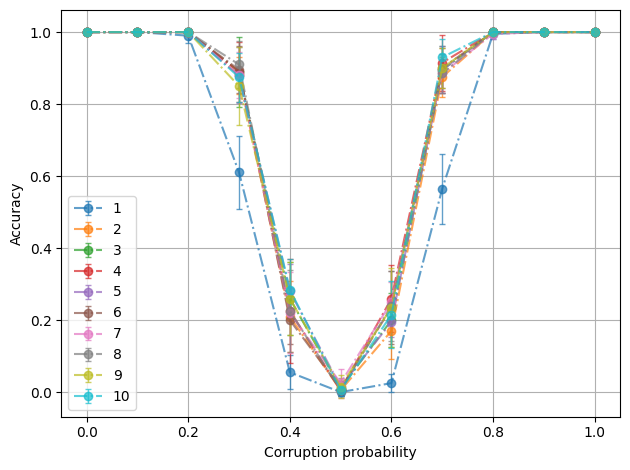

In [73]:
# plotting the results
fig, ax = plt.subplots()

for i, r in enumerate(results):
  ax.errorbar(np.linspace(0,1,corruption_steps), np.mean(r, axis=0), yerr=np.std(r, axis=0), label=f"{epochs[i]}",
              fmt='o-.', capsize=2, alpha=0.7, elinewidth=1, color=colormap.colors[i])

ax.set_xlabel("Corruption probability")
ax.set_ylabel("Accuracy")

ax.legend(loc='lower left')
ax.grid()
fig.tight_layout()

As we can see it is convenient to run the retrieval algorithm for at least 2 iterations, as the performance greatly increases with respect to a single one.

Lastly we want to observe how the number of patterns stored influences the retrieval accuracy.

In [74]:
# hyperparameters of the analysis
pattern_lenght = 25
n_patterns = [10, 50, 100, 500, 1000]
func_type = "Polyn"
poly_deg = 5

epochs = 10
test_size = 20
n_trials = 10
corruption_steps = 11

In [75]:
def corruption_n_patterns_analysis(n_patterns: int):
  """
  `n_patterns`: number of patterns generated \n

  Returns the accuracy of the model for each quantity of corruption. The process is repeated `n_trials` times.
  """

  ts = np.minimum(n_patterns, test_size)

  accuracy = []
  for _ in range(n_trials):
    # initialization of the model and creation of the patterns
    model = modern_hopfield(pattern_lenght=pattern_lenght, func_type=func_type, poly_deg=poly_deg)
    patterns = generate_patterns(pattern_lenght=pattern_lenght, N=n_patterns)
    model.add_patterns(patterns)

    # we now test our model over different (from 0 to 1) probabilities of corruption
    corruption_prob = np.linspace(0, 1, corruption_steps)
    correctly_identified = []
    for q in corruption_prob:
      # selecting a subset of patterns for testing
      perm = np.random.permutation(patterns.shape[0])
      test_patterns = patterns[perm, :][:ts,:]
      corrupted = corrupt_patterns(patterns=test_patterns, q=q,)

      # counting how many tests where succesessful
      c_id = 0 
      for i, c in enumerate(corrupted):
        r = model.retrieve_pattern(c, epochs=epochs)
        if np.array_equal(test_patterns[i,:], r): 
          c_id += 1
      correctly_identified.append(c_id)
    accuracy.append(np.array(correctly_identified) / ts)
  return np.array(accuracy)

In [76]:
# multithreading to speed up the process
pool = Pool(len(n_patterns))
results = pool.map(corruption_n_patterns_analysis, n_patterns)

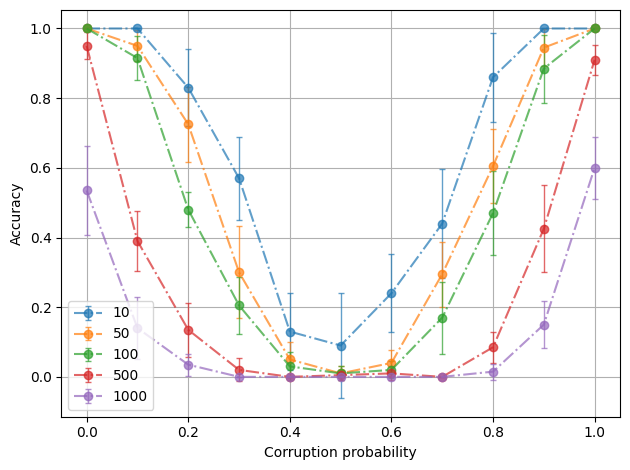

In [77]:
# plotting the results
fig, ax = plt.subplots()

for i, r in enumerate(results):
  ax.errorbar(np.linspace(0,1,corruption_steps), np.mean(r, axis=0), yerr=np.std(r, axis=0), label=f"{n_patterns[i]}",
              fmt='o-.', capsize=2, alpha=0.7, elinewidth=1, color=colormap.colors[i])

ax.set_xlabel("Corruption probability")
ax.set_ylabel("Accuracy")

ax.legend(loc='lower left')
ax.grid()
fig.tight_layout()


As expected, an higher number of patterns stored in memory results in overall worse perfomances over the whole range of $q$.

## Patterns with imbalance in the spins' contentrations

Up until now we have considered patterns where the concentrations of spins where pretty much equal. We want to test how the retrieval ability of the model is affected by an imbalance in the concentrations.

In [78]:
# hyperparameters of the analysis
pattern_lenght = 25
n_patterns = [1, 10, 20, 50, 100, 200, 500, 1000]
func_type = "Polyn"
poly_deg = 5

epochs = 10
test_size = 20
n_trials = 10
q_steps = 11

In [79]:
# i want to check the accuracy of the model when the concentration of spins and the number of pattern stored varies
def imbalance_n_patterns_analysis(q: float):

  accuracy = []
  for _ in range(n_trials):
    correcly_identified = []
    for n_p in n_patterns:
      model = modern_hopfield(pattern_lenght=pattern_lenght, func_type=func_type, poly_deg=poly_deg)
      patterns = generate_patterns(pattern_lenght=pattern_lenght, N=n_p, q=q)
      model.add_patterns(patterns)
  
      ts = np.minimum(n_p, test_size)
      perm = np.random.permutation(n_p)
      test_patterns = patterns[perm, :][:ts,:]

      c_id = 0
      for i, t in enumerate(test_patterns):
        r = model.retrieve_pattern(t, epochs=epochs)
        if np.array_equal(test_patterns[i], r):
          c_id += 1
      correcly_identified.append(c_id / ts)
    accuracy.append(np.array(correcly_identified))
  return np.array(accuracy)          

In [80]:
# multithreading
n1 = 6
n2 = q_steps - n1
q = np.linspace(0, 1, q_steps)
pool = Pool(n1)
results = pool.map(imbalance_n_patterns_analysis, q[:n1])
pool = Pool(n2)
results.extend(pool.map(imbalance_n_patterns_analysis, q[n1:]))

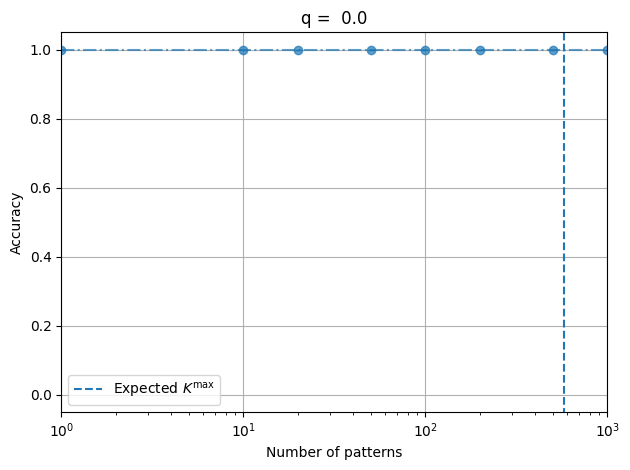

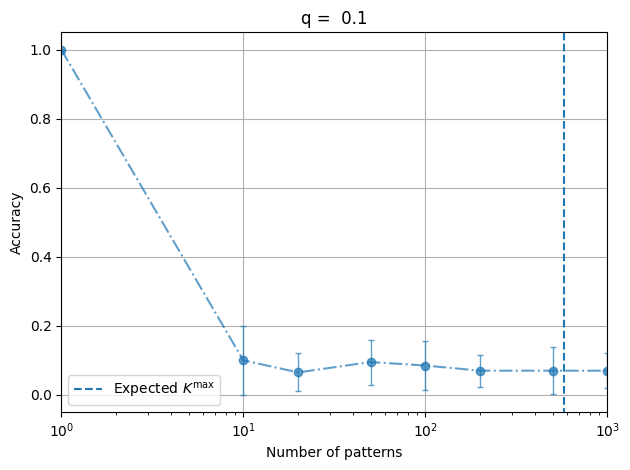

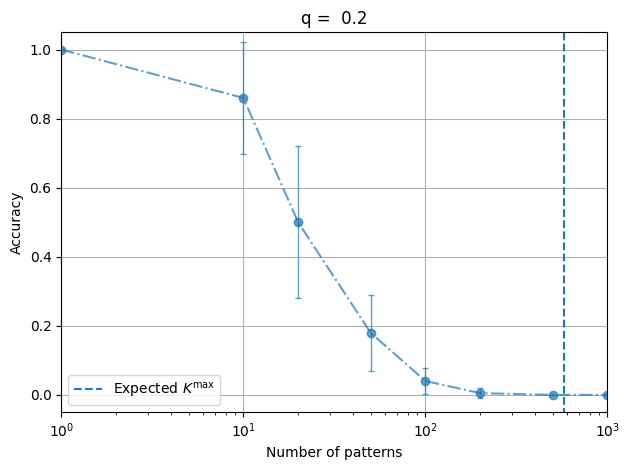

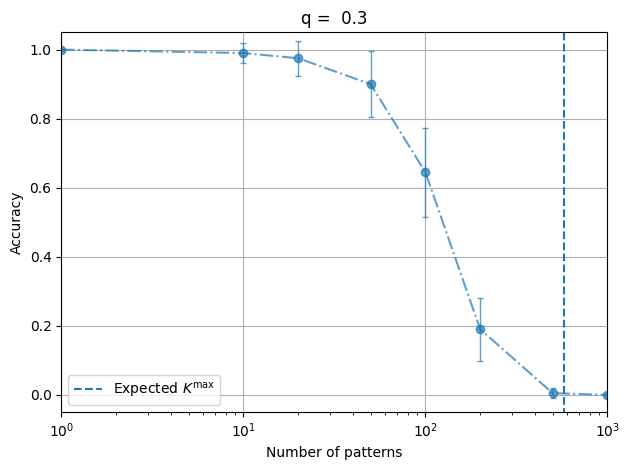

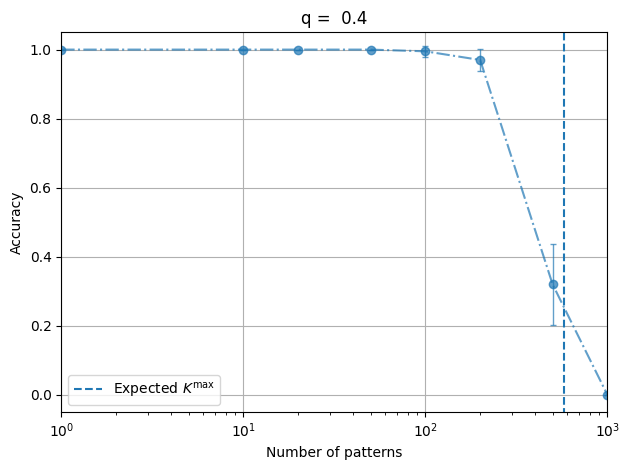

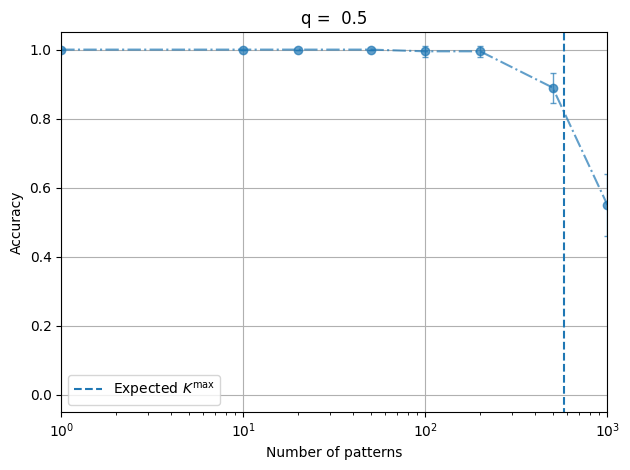

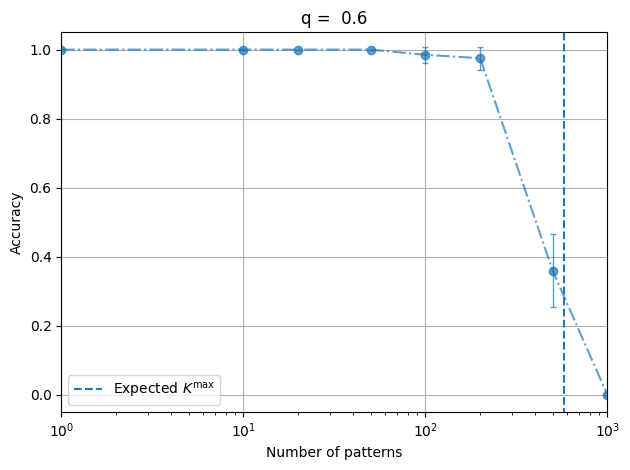

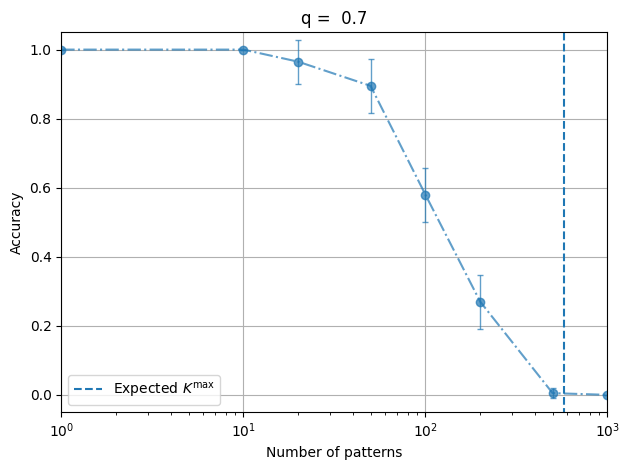

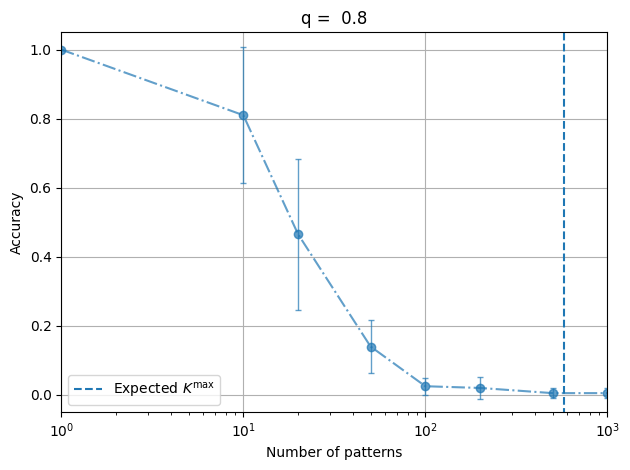

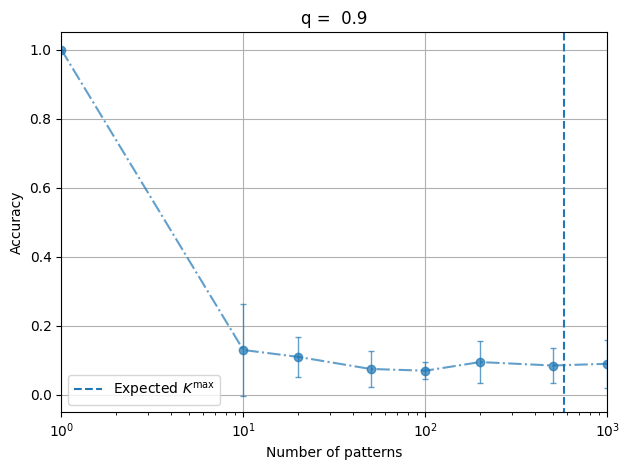

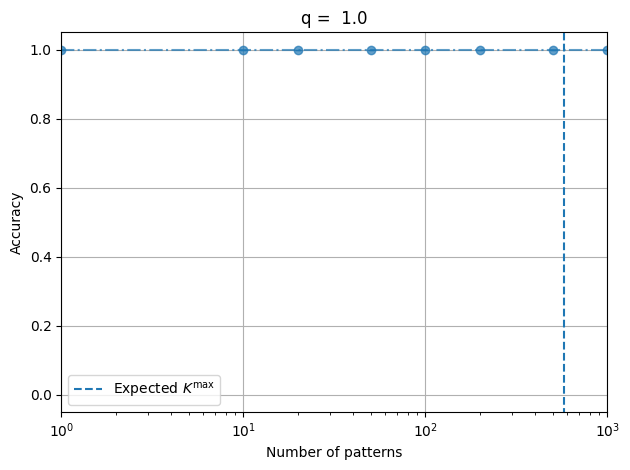

In [83]:
# plotting the results

for i, r in enumerate(results):
  fig, ax = plt.subplots()
  
  ax.errorbar(n_patterns, np.mean(r, axis=0), yerr=np.std(r, axis=0),
              fmt='o-.', capsize=2, alpha=0.7, elinewidth=1)
  
  expected_kmax = maximum_recall(pattern_lenght=pattern_lenght, degree=poly_deg)
  ax.vlines(expected_kmax, ymin=-1, ymax=2, label=r"Expected $K^{\text{max}}$", linestyles="--")
  
  ax.legend(loc='lower left')
  ax.set_ylim(-0.05, 1.05)
  ax.set_xlim(n_patterns[0], n_patterns[-1])
  ax.set_xlabel("Number of patterns")
  ax.set_ylabel("Accuracy")
  ax.set_title(f"q = {q[i]: .1f}")
  ax.set_xscale('log')
  ax.grid()
  fig.tight_layout()

In conclusion we observe that an imbalance in the spin concentrations results in a reduced storage capacity. 

# Section 4